In [20]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, roc_auc_score
import pickle

In [21]:
PROJ_ROOT = '/Users/mloui/Documents/STAR/SOFAR'

### Least Squares Regression

In [3]:
# Independent dynamic relationship of each variable
def autoregressive_model(data, M):
    N = data.shape[0]
    num_vars = data.shape[1]
    A = np.zeros((num_vars, N-M, M))
    for v in range(num_vars):
        for i in range(N-M):
            A[v, i, :] = data[i:i+M, v]
    b = data.T[:,M:]
    return A, b

def solve_beta(A, b):
    betas = []
    for i in range(len(A)):
        betas.append(np.linalg.lstsq(A[i], b[i], rcond=None)[0])
    betas = np.array(betas)
    return betas

# Includes dynamic relationship between variables
'''
def autoregressive_model(data, M):
    N = data.shape[0]
    num_vars = data.shape[1]
    A = np.zeros((N-M, M*num_vars))
    for i in range(N-M):
        A[i, :] = data[i:i+M, :].flatten(order='F')
    b = data.T[:,M:]
    return A, b

def solve_beta(A, b):
    betas = []
    for i in range(len(b)):
        betas.append(np.linalg.lstsq(A, b[i], rcond=None)[0])
    betas = np.array(betas)
    return beta
'''

"\ndef autoregressive_model(data, M):\n    N = data.shape[0]\n    num_vars = data.shape[1]\n    A = np.zeros((N-M, M*num_vars))\n    for i in range(N-M):\n        A[i, :] = data[i:i+M, :].flatten(order='F')\n    b = data.T[:,M:]\n    return A, b\n\ndef solve_beta(A, b):\n    betas = []\n    for i in range(len(b)):\n        betas.append(np.linalg.lstsq(A, b[i], rcond=None)[0])\n    betas = np.array(betas)\n    return beta\n"

### Kalman Filter

In [4]:
class KalmanFilter():
    def __init__(self, beta, R, Q):
        """
        Initialize the Kalman Filter.
        """
        self.beta = beta
        self.M = len(beta) #number of old temp measurements to keep
        self.x_hat = np.zeros(self.M) #predicted state variable
        self.P = np.zeros((self.M, self.M)) #state covariance matrix
        self.R = R #measurement noise
        self.Q = Q #process noise
        self.F = np.block([
            [np.eye(self.M)[1:]],
            [self.beta.T]
            ]) #transition matrix
        self.H = np.block([
            [np.zeros(self.M-1), np.array([1])]
            ])
    
    def update(self, sensor_update):
        """
        Update the state based on the
        sensor inputs.
        """
        #Prediction step (update state + cov based on dynamics)
        x_hat_pred = self.F@self.x_hat
        P_pred = self.F@self.P@self.F.T + self.Q
        
        #Update step (update based on sensor measurement)
        innovation_residual = sensor_update-self.H@x_hat_pred
        S = self.H@P_pred@self.H.T + self.R
        K = P_pred@self.H.T@np.linalg.inv(S)
        x_hat_update = x_hat_pred + K@innovation_residual
        P_update = (np.eye(self.M)-K@self.H)@P_pred
        post_fit_residual = sensor_update-self.H@x_hat_update
        
        self.x_hat = x_hat_update
        self.P = P_update
        self.S = S
        #For some reason, IMM depends on innovation residual
        #rather than post-fit
        self.residual = innovation_residual
    
    def get_state_estimate(self):
        return self.x_hat
    
    def get_residual(self):
        return self.residual
    
    def get_residual_covariance(self):
        return self.S

In [5]:
# Predict and update Kalman Filters with data, return residual error
def KF_data(kfs, data):
    res = np.zeros((data.shape))
    bar = tqdm.tqdm(total=len(data))
    for i, d in enumerate(data):
        # Predict and update with sensor measurement
        for j in range(len(kfs)):
            kfs[j].update(d[j])
            res[i,j] = kfs[j].get_residual()
        bar.update()
    bar.close()
    return res

In [40]:
# Load Quickscat data
'''
all_data = np.loadtxt(f'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/normal_quickscat.csv',
                 delimiter=",", dtype=str)
print(all_data.shape)

data = all_data[1:,1:].astype(float)
print(data.shape)
'''

(500965, 11)
(500964, 10)


In [32]:
# Load simulated normal data
df = pd.read_csv(f'{PROJ_ROOT}/data/simulated/sim_train1.csv')
data = df.to_numpy()[:,:-3]
print(data.shape)
print(data[10])

(540000, 13)
[ 4.27489169  1.61377738  3.28712251  7.9413146   0.25554456  0.63067393
  7.96395936  0.26761411  0.20830884 -0.51720671  0.15783271  0.18073429
 10.        ]


In [33]:
# Learn least squares regression for time series for each variable
M = 20
A, b = autoregressive_model(data, M)
print(A.shape)
print(b.shape)
beta = solve_beta(A, b)
print(beta.shape)

(13, 539980, 20)
(13, 539980)
(13, 20)


In [34]:
# Init kalman filters for each variable
R = np.array([1e-5]) #measurement noise covariance (e.g. SNR) - can be varied
Q = np.eye(M)*1e-5 #process noise covariance (includes hidden variables) - can be varied
kfs = []
for i in range(data.shape[1]):
    kfs.append(KalmanFilter(beta[i], R, Q))
print(len(kfs))

13


In [35]:
# Train
res = KF_data(kfs, data)

100%|█████████████████████████████████| 540000/540000 [04:28<00:00, 2010.73it/s]


In [38]:
# Save model
with open(f'{PROJ_ROOT}/models/kf.pkl', 'wb') as handle:
    pickle.dump(kfs, handle)

In [30]:
# Load faulting Quickscat data
'''
fault_data = np.loadtxt(f'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/fault_quickscat.csv',
                 delimiter=",", dtype=str)

f_data = fault_data[1:,1:].astype(float)
print(f_data.shape)
'''

'\nfault_data = np.loadtxt(f\'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/fault_quickscat.csv\',\n                 delimiter=",", dtype=str)\n\nf_data = fault_data[1:,1:].astype(float)\nprint(f_data.shape)\n'

In [117]:
# Test
res = KF_data(kfs, f_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104544/104544 [00:37<00:00, 2770.86it/s]


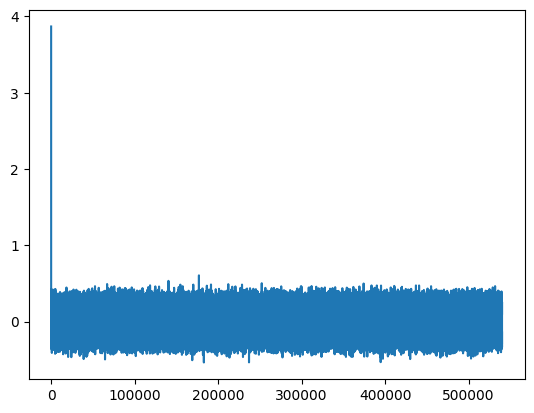

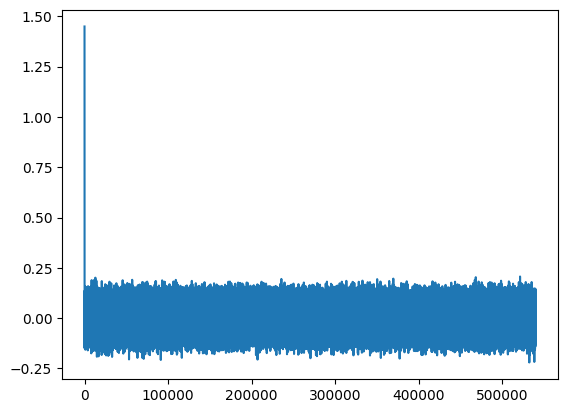

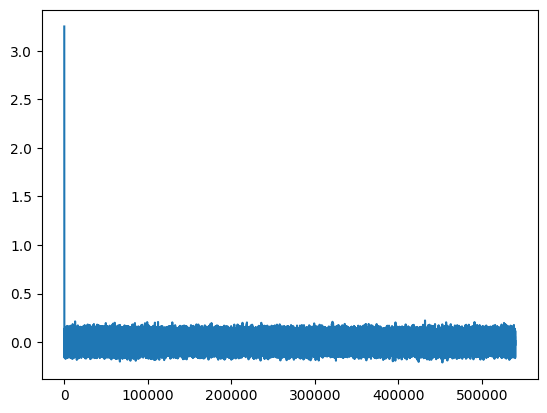

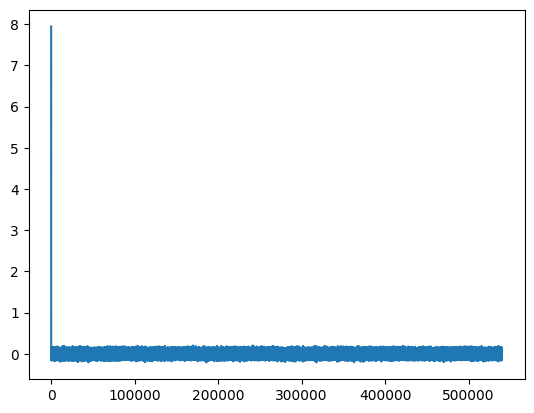

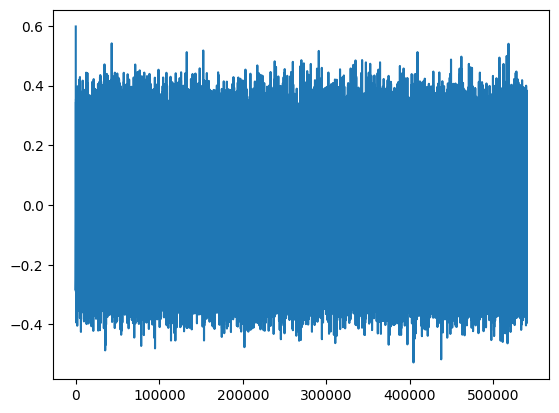

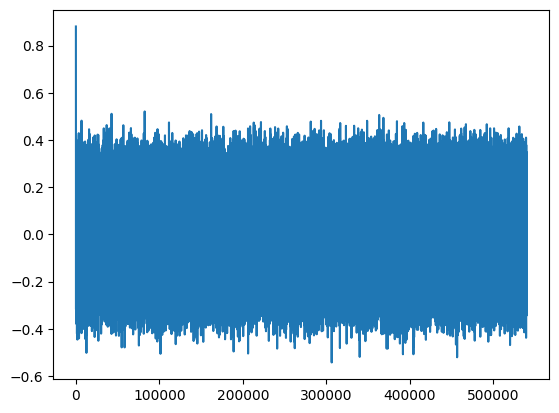

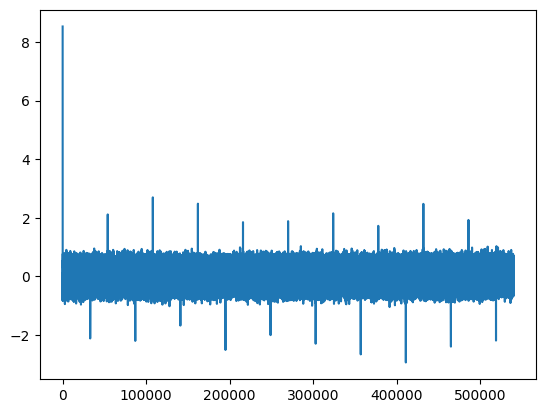

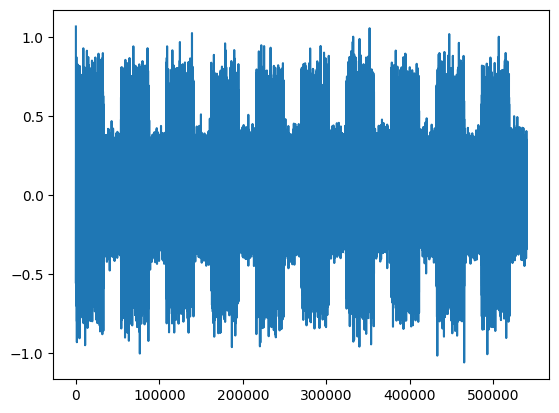

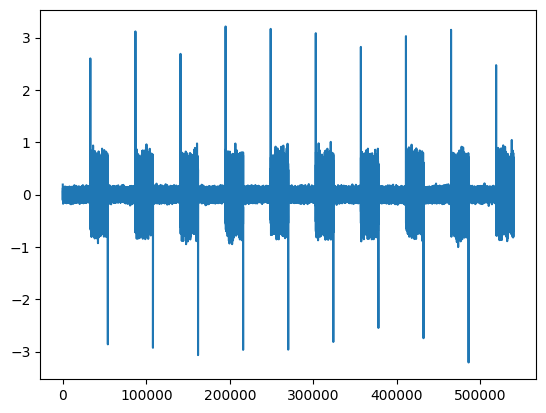

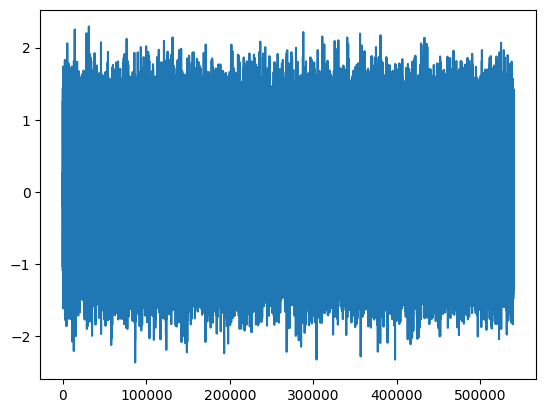

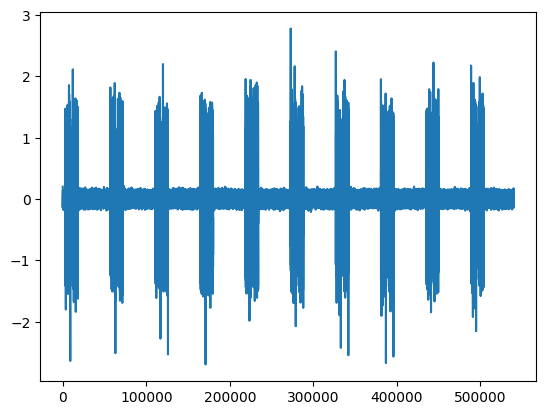

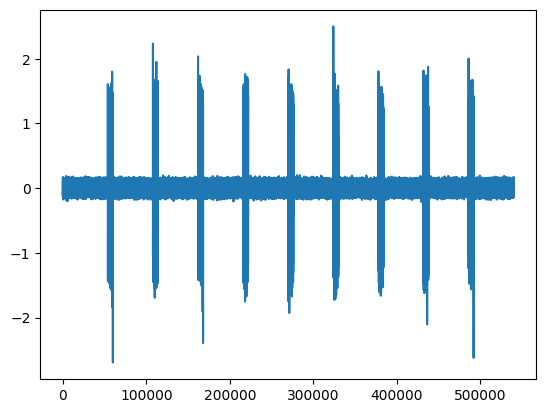

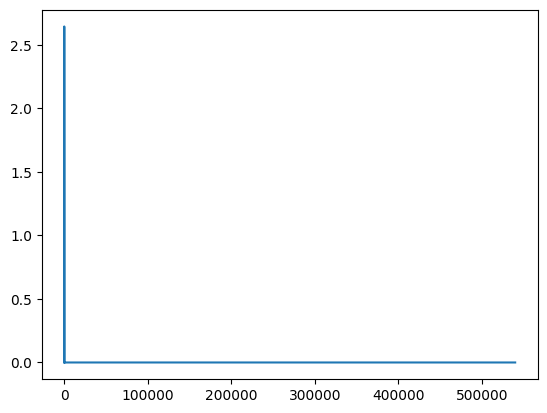

In [37]:
for i in range(res.shape[1]):
    plt.plot(res[:,i])
    plt.show()

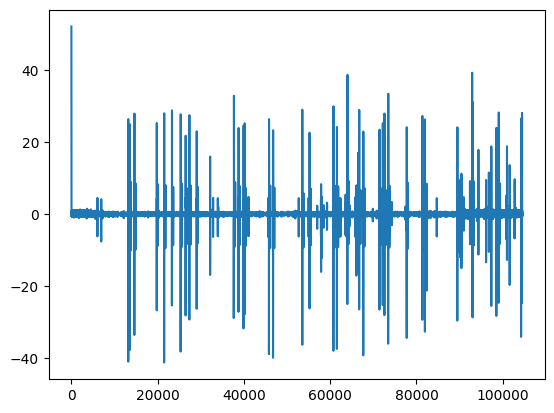

In [119]:
avg_res = np.sum(res, axis=1)/res.shape[1]
plt.plot(avg_res)
plt.show()

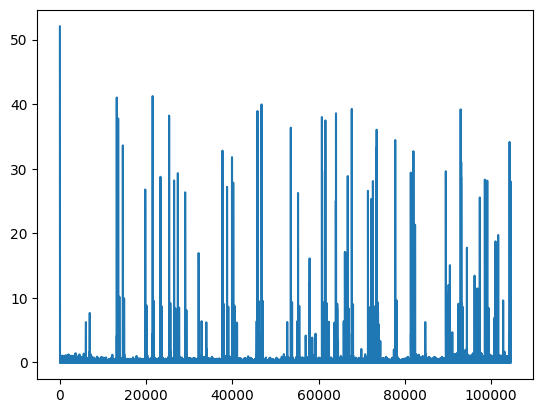

In [120]:
plt.plot(np.absolute(avg_res))
plt.show()

### Verify

In [121]:
# Load GT
gt_f_data = pd.read_csv(f'{PROJ_ROOT}/data/NASA_R3/raw_telemetry/quickscat/fault_quickscat_gt_IRFCauseZeros.csv')
gt_faults = np.array(gt_f_data['Fault']).astype(int)
print(gt_faults.shape)
print(f'{np.sum(gt_faults)} faults in ground truth')

(104544,)
1269 faults in ground truth


In [122]:
# Use average and absolute value of the residual error
abs_avg_res = np.absolute(avg_res)
fpr, tpr, thres = roc_curve(gt_faults, abs_avg_res)

AUC: 0.9326857550752645


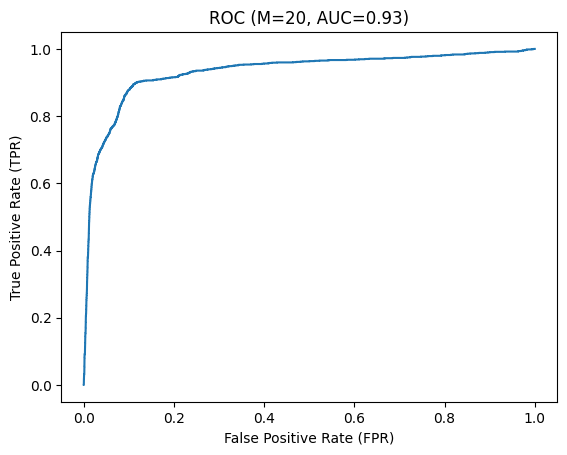

In [123]:
# Calculate AUC
auc = roc_auc_score(gt_faults, abs_avg_res)
print(f'AUC: {auc}')

# Plot
plt.plot(fpr, tpr)
plt.title(f'ROC (M={M}, AUC={auc:.2f})')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()